In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# EDA

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s5e7/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s5e7/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')

In [3]:
train.shape

(18524, 9)

In [4]:
train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [5]:
train.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [6]:
for col in train.columns:
    print(col)

id
Time_spent_Alone
Stage_fear
Social_event_attendance
Going_outside
Drained_after_socializing
Friends_circle_size
Post_frequency
Personality


Counting the missing values per column

In [7]:
print('Missing values')
for col in train.columns:
    missing = train[col].isna().sum()
    if missing > 0:
        print(f"{col}: {missing}")

Missing values
Time_spent_Alone: 1190
Stage_fear: 1893
Social_event_attendance: 1180
Going_outside: 1466
Drained_after_socializing: 1149
Friends_circle_size: 1054
Post_frequency: 1264


Filling the missing values with the mode

In [8]:
for col in train:
    mode_val = train[col].mode()
    if not mode_val.empty:
        train[col].fillna(mode_val[0], inplace=True) 

/tmp/ipykernel_13/438068567.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(mode_val[0], inplace=True)


<Axes: >

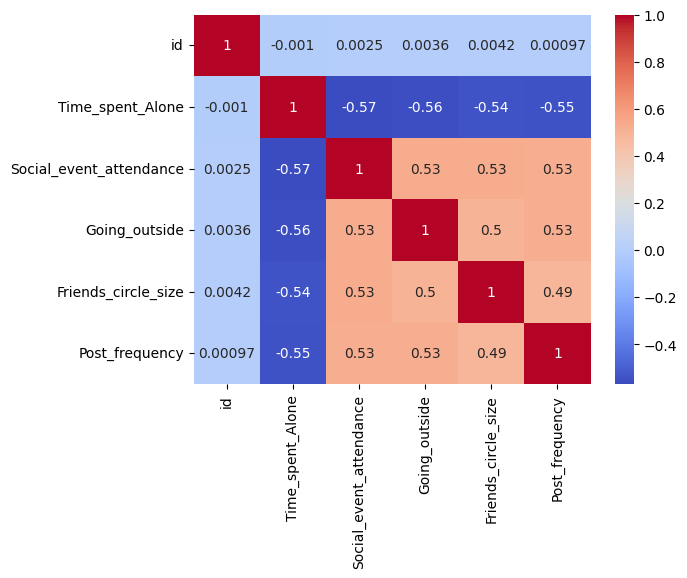

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns

numerical_values = train.select_dtypes(include=('number'))
corr = numerical_values.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')

Distributions

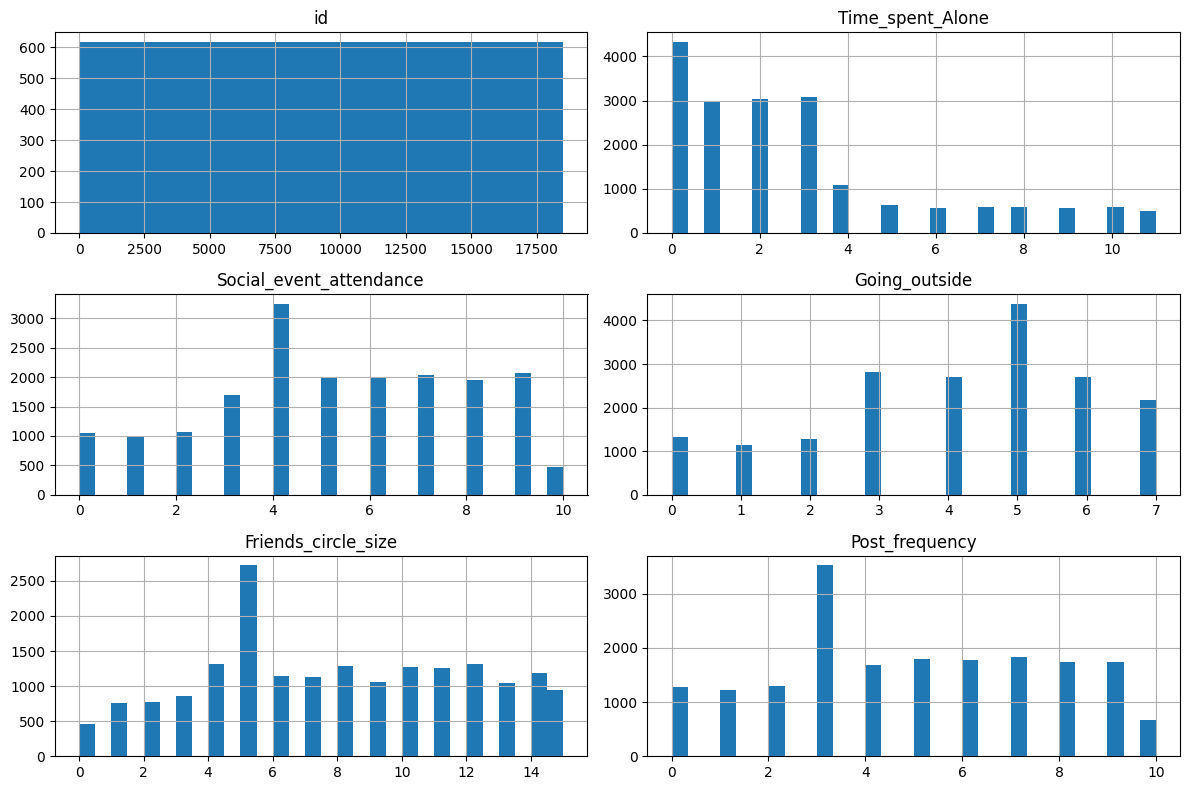

In [10]:
train.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

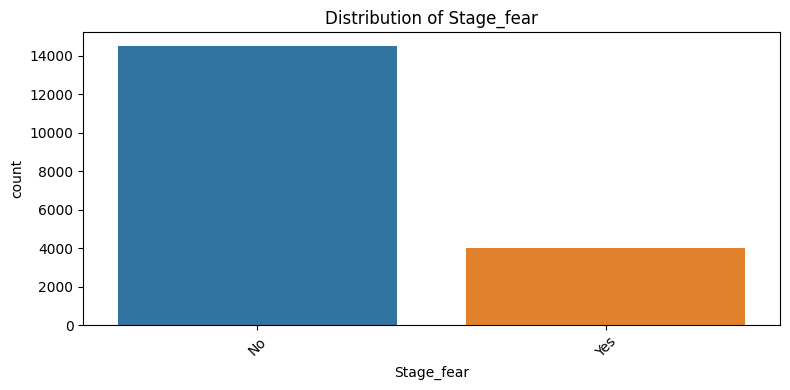

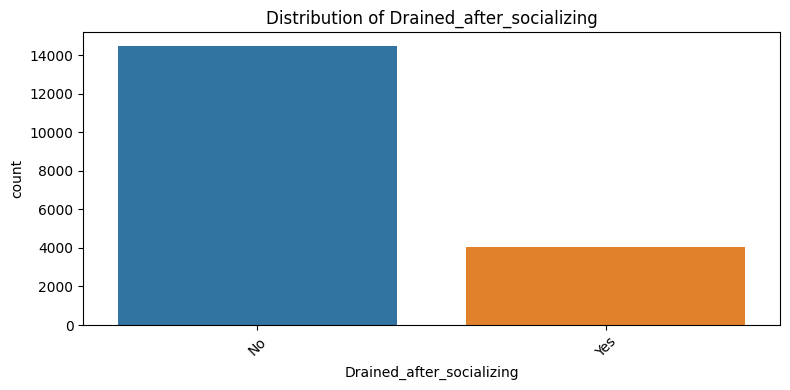

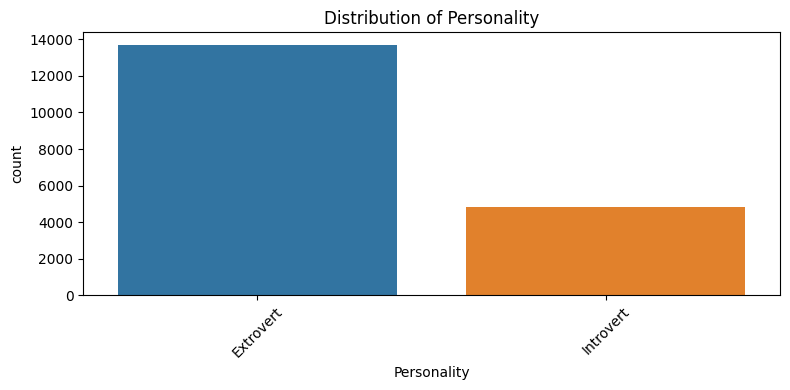

In [11]:
categorical_cols = train.select_dtypes(include=(['object', 'category']))

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=train, order=train[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Interesting correlations

In [12]:
extroverts_with_stage_fear = train[
    (train['Personality'] == 'Extrovert') &
    (train['Stage_fear'] == 'Yes')
]

ratio = (extroverts_with_stage_fear.shape[0] / train.shape[0]) * 100
ratio1 = (extroverts_with_stage_fear.shape[0] / train[train['Personality'] == 'Extrovert'].shape[0]) * 100
print(f"Percentage of extroverts with stage fear (compared to the full population): {ratio}")
print(f"Percentage of extroverts with stage fear (compared to the population of extroverts): {ratio1}")

Percentage of extroverts with stage fear (compared to the full population): 1.2740228892247896
Percentage of extroverts with stage fear (compared to the population of extroverts): 1.7227534856558873


In [13]:
introverts_with_stage_frear = train[
    (train['Personality'] == 'Introvert') &
    (train['Stage_fear'] == 'Yes')
]

ratio = (introverts_with_stage_frear.shape[0] / train.shape[0]) * 100
ratio1 = (introverts_with_stage_frear.shape[0] / train[train['Personality'] == 'Introvert'].shape[0]) * 100
print(f"Percentage of introverts with stage fear (compared to the full population): {ratio}")
print(f"Percentage of introverts with stage fear (compared to the population of introverts): {ratio1}")

Percentage of introverts with stage fear (compared to the full population): 20.438350248326493
Percentage of introverts with stage fear (compared to the population of introverts): 78.46632124352332


In [14]:
ratio = (train[train['Stage_fear'] == 'Yes'].shape[0] / train.shape[0]) * 100
print(f"Percentage of people who have stage fear: {ratio}")

Percentage of people who have stage fear: 21.712373137551285


# Data preprocessing

In [15]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = train.select_dtypes(include=['object', 'category'])

le = LabelEncoder()

for col in categorical_cols:
    train[col] = le.fit_transform(train[col])
    # test[col] = le.fit_transform(test[col])

In [16]:
print(f'Test cols: {test.shape[1]}, Train cols: {train.shape[1]}')

Test cols: 8, Train cols: 9


# Model building

Logistic regression

In [17]:
print(train.isna().sum())

id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64


In [18]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = train.drop('Personality', axis=1)  
y = train['Personality']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression(max_iter=1000)  # Optional: increase max_iter if you see convergence warnings
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion matrix:\n{confusion_matrix(y_test, y_pred)}')
print(f'Classification report:\n{classification_report(y_test, y_pred)}')

Accuracy: 0.9686909581646423
Confusion matrix:
[[2703   50]
 [  66  886]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2753
           1       0.95      0.93      0.94       952

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705

